In [18]:
# import de nodige packages
import os
import sys
import re
import math
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from functions.data_loader import data_loader
from classes.smiles_to_graph import MolecularGraphFromSMILES
from classes.MPNN import MPNN
from functions.compute_loss import compute_loss
from functions.evaluations import evaluate_yield
from functions.evaluations import evaluate_borylation_site
from functions.evaluations import evaluate_reactivity
from functions.evaluations import evaluate_model
from functions.train import train

# Load the data and couple the SMILES to the yields and remove nan's

In [19]:

yields_path = "data/compounds_yield.csv"
smiles_path = "data/compounds_smiles.csv"

df_merged = data_loader(yields_path, smiles_path)


print("Merged DataFrame:")
print(df_merged)


Merged DataFrame:
   compound_id                                        smiles_raw  \
0        comp1                            C1C2=C(N=C(O2)C)C=CC=1   
1        comp2                        C1C2=C(N=C(O2)C)C=C(Br)C=1   
2        comp3                            C1C2=C(N=C(N2)C)C=CC=1   
3        comp4                          C1(Cl)=CC=NC2NC(C)=CC1=2   
4        comp5                        C1C2=C(N=C(O2)C)C=C(OC)C=1   
..         ...                                               ...   
78      comp88  C1C=CC=C2N(C(=O)OC(C)(C)C)C=C([Si]([H])(C)C)C=12   
79      comp91                                    C1=CC(F)=NC=C1   
80      comp92                                    C1=CC(F)=NC=C1   
81      comp93                                    C1=CC(F)=NC=C1   
82      comp97                           N1=CC=C(C(F)(F)F)C=C1Cl   

   borylation_site  yield  
0                1     68  
1               11     86  
2                2     94  
3               10     72  
4                1     81

Convert the SMILES to Graphs

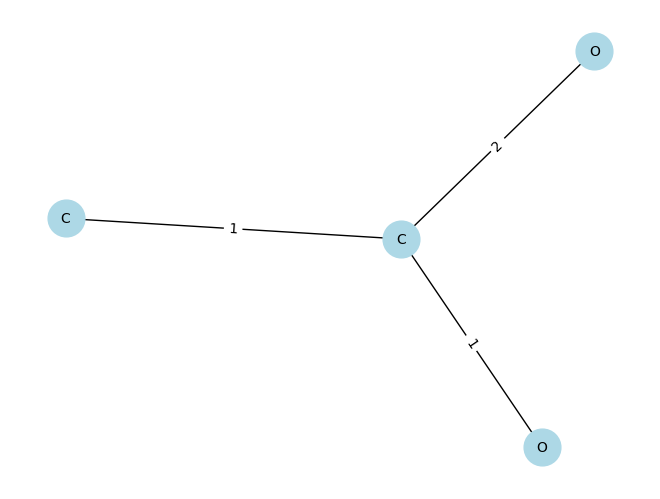

Data(x=[4, 16], edge_index=[2, 6], edge_attr=[6, 3])


In [20]:
# Dit laat zien dat onze class werkt ->uiteindelijk overbodig denk ik

# Create a molecule from a SMILES string
smiles = "CC(=O)O"  
mol_graph = MolecularGraphFromSMILES(smiles)

# Visualize the molecule with bond orders
mol_graph.visualize()

# Convert to PyTorch Geometric format
pyg_data = mol_graph.to_pyg_data()
print(pyg_data)

## Zet de SMILES om naar graphs

In [9]:

graphs = []
for _, row in tqdm(df_merged.iterrows(), total=len(df_merged), desc="Converting SMILES to graphs"):
    try:
        graph = MolecularGraphFromSMILES(row['smiles_raw']).to_pyg_data()
        graph.y = torch.tensor([row['yield']], dtype=torch.float)
        graphs.append(graph)
    except Exception as e:
        print(f"Fout bij SMILES: {row['smiles_raw']}, error: {e}")


Converting SMILES to graphs: 100%|██████████| 83/83 [00:00<00:00, 1226.50it/s]


## Zet de graphs in een dataloader zodat het de GNN in kan

In [10]:
import torch
from torch_geometric.loader import DataLoader

# Ik krijg een fout melding maar ChatGPT zegt dit: self.gnn_layer = NNConv(
    #in_channels=hidden_feats,
    #out_channels=hidden_feats,
    #nn=edge_network,
    #aggr='sum'
#)
# Split de lijst met graphs
train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

# Maak DataLoaders aan voor training en evaluatie
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Instellingen
batch_size = 32
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Aantal kenmerken per node en edge
node_in_feats = 128 
edge_in_feats = 64
  
# Grootte van de verborgen laag
hidden_feats = 64 

# Dataloader
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

# Initialiseer model
model = MPNN(node_in_feats=node_in_feats, edge_in_feats=edge_in_feats, hidden_feats=hidden_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Dit werkt volgens mij niet helemaal zo want we hebben ook nog compute_loss->want 
    # want nu doet ie loss in train maar train is includes al de loss
    loss = train(model, train_loader, optimizer, device)
    print(f"[Epoch {epoch+1}] Training loss: {loss:.4f}")

# Evaluatie na training
metrics = evaluate_model(model, train_loader, device)
print("Train metrics:", metrics)




TypeError: NNConv.__init__() missing 3 required positional arguments: 'in_channels', 'out_channels', and 'nn'

In [ ]:
from sklearn.model_selection import KFold
from torch_geometric.loader import DataLoader
import torch

# Instellingen
k_folds = 5
batch_size = 16
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
all_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs)):
    print(f"\n🟦 Fold {fold+1}/{k_folds}")
    
    # Split data
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

    # Init model and optimizer
    model = MPNN(node_in_feats=128, edge_in_feats=64, hidden_feats=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train
    for epoch in range(num_epochs):
        loss = train(model, train_loader, optimizer, device)
        print(f"  [Epoch {epoch+1}] Loss: {loss:.4f}")

    # Evaluate
    fold_metrics = evaluate_model(model, val_loader, device)
    print(f"  🔎 Metrics Fold {fold+1}:", fold_metrics)
    all_metrics.append(fold_metrics)

# Gemiddelde prestaties
print("\n📊 Gemiddelde metrics over alle folds:")
from collections import defaultdict
import numpy as np

avg_metrics = defaultdict(list)
for metric_dict in all_metrics:
    for k, v in metric_dict.items():
        avg_metrics[k].append(v)

for k, v_list in avg_metrics.items():
    print(f"{k}: {np.mean(v_list):.4f} ± {np.std(v_list):.4f}")

New version of code used above

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from collections import defaultdict
import numpy as np

# --- Training Function ---
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)

        optimizer.zero_grad()
        p_borylation, reactivity_score, predicted_yield = model(
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        # Losses
        loss_bce = F.binary_cross_entropy_with_logits(p_borylation, data.p_borylation.float())
        loss_mse_node = F.mse_loss(reactivity_score, data.reactivity_score)
        loss_mse_graph = F.mse_loss(predicted_yield, data.y)

        loss = loss_bce + loss_mse_node + loss_mse_graph
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

# --- Evaluation Function ---
@torch.no_grad()
def evaluate_model(model, loader, device):
    model.eval()
    bce_losses = []
    node_mse_losses = []
    graph_mse_losses = []

    for data in loader:
        data = data.to(device)
        p_borylation, reactivity_score, predicted_yield = model(
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        bce = F.binary_cross_entropy_with_logits(p_borylation, data.p_borylation.float()).item()
        node_mse = F.mse_loss(reactivity_score, data.reactivity_score).item()
        graph_mse = F.mse_loss(predicted_yield, data.y).item()

        bce_losses.append(bce)
        node_mse_losses.append(node_mse)
        graph_mse_losses.append(graph_mse)

    return {
        "BCE_loss": np.mean(bce_losses),
        "Node_MSE": np.mean(node_mse_losses),
        "Graph_MSE": np.mean(graph_mse_losses)
    }

# --- Main K-Fold Loop ---
def run_k_fold(graphs, k_folds=5, batch_size=16, num_epochs=20, learning_rate=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(graphs)):
        print(f"\n🟦 Fold {fold+1}/{k_folds}")

        train_graphs = [graphs[i] for i in train_idx]
        val_graphs = [graphs[i] for i in val_idx]

        train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

        model = MPNN(
            node_in_feats=graphs[0].x.size(-1),
            edge_in_feats=graphs[0].edge_attr.size(-1),
            hidden_feats=64
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            loss = train(model, train_loader, optimizer, device)
            print(f"  [Epoch {epoch+1}] Loss: {loss:.4f}")

        fold_metrics = evaluate_model(model, val_loader, device)
        print(f"  🔎 Metrics Fold {fold+1}:", fold_metrics)
        all_metrics.append(fold_metrics)

    print("\n📊 Gemiddelde metrics over alle folds:")
    avg_metrics = defaultdict(list)
    for metric_dict in all_metrics:
        for k, v in metric_dict.items():
            avg_metrics[k].append(v)

    for k, v_list in avg_metrics.items():
        print(f"{k}: {np.mean(v_list):.4f} ± {np.std(v_list):.4f}")

# --- Example usage (assuming your dataset is ready) ---
# run_k_fold(graphs, k_folds=5, batch_size=16, num_epochs=20)


In [12]:
# ik moet nog even kijken wat ik hiervan nodig heb als ik de k fold wil introduceren -> en of ik uberhaupt
# hier iets van nodig heb
# Split de lijst met graphs
train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

# Maak DataLoaders aan voor training en evaluatie
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

In [13]:
# Dit wordt miss de k fold validation geintrepeteerd-> dit zou betekenen denk ik dat
# de vorige cell overboden zou worden
# graphs zijn onze smiles in een lijst

from sklearn.model_selection import KFold
from torch_geometric.loader import DataLoader

# Deze getallen zijn nog arbitrary, maar dit zijn de nodige dingen die we kunnen veranderen
# Initialisering voor de k_fold
k_folds = 5
batch_size = 16
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


# Aantal kenmerken per node en edge
node_in_feats = 128 
edge_in_feats = 64  
# Grootte van de verborgen laag
hidden_feats = 64 


# Initialisering model
model = MPNN(node_in_feats=node_in_feats, edge_in_feats=edge_in_feats, hidden_feats=hidden_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, test_idx) in enumerate(kf.split(graphs)):
    print(f'Fold {fold + 1}')
    
    train_graphs = [graphs[i] for i in train_idx]
    test_graphs = [graphs[i] for i in test_idx]

    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

    # of initialiseer ik het model zo
    model = train(model, train_loader, optimizer, device)

    # Voor elke batch in de train_loader (trainen per fold)
    for batch in train_loader:
        x = batch.x
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr
        y = batch.y
        batch_vector = batch.batch

        # Hier voer je het model uit, verliesfunctie berekenen, backpropagation etc.
        # Bijvoorbeeld:
        # output = model(x, edge_index, edge_attr, batch_vector)
        # loss = loss_fn(output, y)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

    

TypeError: NNConv.__init__() missing 3 required positional arguments: 'in_channels', 'out_channels', and 'nn'